In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd
import proplot as plot

Inputs

In [2]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH = 32.4  # inches

In [3]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH  # meters

In [4]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

In [5]:
dimensions_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_df.columns = [col.strip() for col in dimensions_df.columns]
dimensions_df = dimensions_df[["radius", "chord"]]

# Convert to international units
dimensions_df = dimensions_df.mul(INCH_METER)

# Name
dimensions_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

for idx, row in dimensions_df.iterrows():

    r = row["radius"]

    # Constant pitch law
    tan_theta = PITCH / (2.0 * np.pi * r) 
    theta = np.arctan(tan_theta)  # radians
    theta = np.rad2deg(theta)  # degrees

    dimensions_df.loc[idx, "theta"] = theta

dimensions_df

,radius,chord,theta
Hub,0.1016,0.06223,52.199199
S1,0.1778,0.06858,36.377590
S2,0.2540,0.06858,27.278439
S3,0.3302,0.06858,21.636400
S4,0.4064,0.06858,17.863548
Tip,0.4572,0.06858,15.985890


array([<AxesSubplot:xlabel='radius'>, <AxesSubplot:xlabel='radius'>],
      dtype=object)

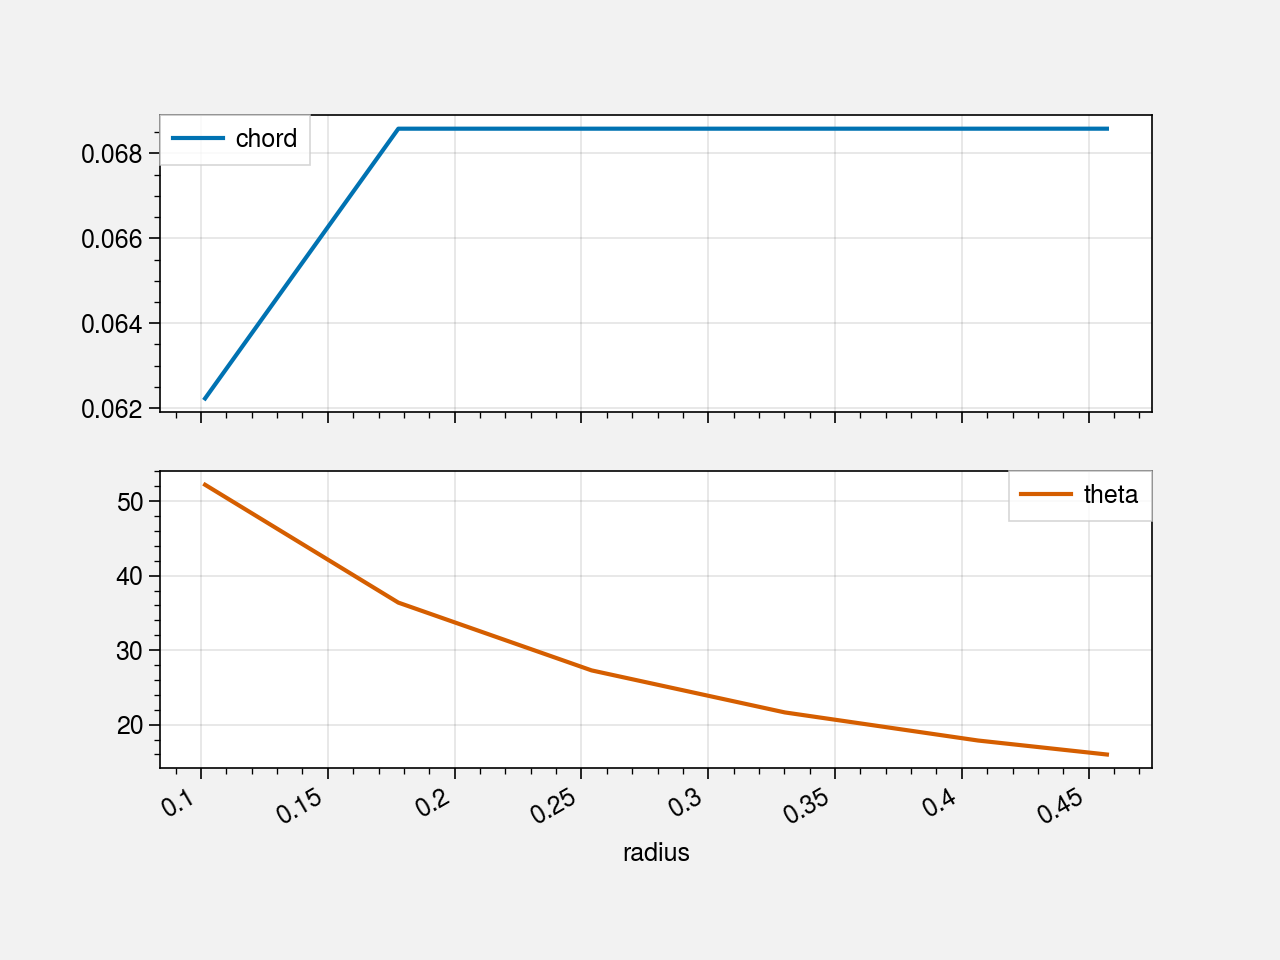

In [6]:
dimensions_df.set_index("radius").plot(subplots=True)

Create the blade by defining the sections at each stage.

In [7]:
# Define known sections
sections = [
    pb.Section(
        name="Hub",
        r=dimensions_df.loc["Hub", "radius"],
        beta=dimensions_df.loc["Hub", "theta"],
        chord=dimensions_df.loc["Hub", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S1",
        r=dimensions_df.loc["S1", "radius"],
        beta=dimensions_df.loc["S1", "theta"],
        chord=dimensions_df.loc["S1", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S2",
        r=dimensions_df.loc["S2", "radius"],
        beta=dimensions_df.loc["S2", "theta"],
        chord=dimensions_df.loc["S2", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="764", which="cl"),
            polar_cd=load_polar(airfoil_type="764", which="cd"),
        ),
    ),
    pb.Section(
        name="S3",
        r=dimensions_df.loc["S3", "radius"],
        beta=dimensions_df.loc["S3", "theta"],
        chord=dimensions_df.loc["S3", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="763", which="cl"),
            polar_cd=load_polar(airfoil_type="763", which="cd"),
        ),
    ),
    pb.Section(
        name="S4",
        r=dimensions_df.loc["S4", "radius"],
        beta=dimensions_df.loc["S4", "theta"],
        chord=dimensions_df.loc["S4", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="762", which="cl"),
            polar_cd=load_polar(airfoil_type="762", which="cd"),
        ),
    ),
    pb.Section(
        name="Tip",
        r=dimensions_df.loc["Tip", "radius"],
        beta=dimensions_df.loc["Tip", "theta"],
        chord=dimensions_df.loc["Tip", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="761", which="cl"),
            polar_cd=load_polar(airfoil_type="761", which="cd"),
        ),
    ),
]

In [11]:
# Define propeller
B0 = 1
BF = 10

results = []
for B in range(B0, BF+1, 2):
    
    propeller = pb.Propeller(B=B, sections=sections)

    # Define flow conditions and BEM method

    for J in np.linspace(1e-1, 1.5):

        pi = np.pi

        _lambda = J / pi

        bem = pb.BladeElementMethod(
            _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
        )

        try:
            # Solve
            bem.solve()
            CT, CQ = bem.integrate_forces()
        except:
            CT = np.nan
            CQ = np.nan
            
        # Create experiments non-dimensionless coefficients
        results.append(
            (
                B,
                J,
                CT * (pi ** 3.0) / 4 / J**2.0,
                CQ * (pi ** 4.0) / 4 / J**2.0,
                _lambda * CT / CQ,  # efficiency
            )
        )
        
        del bem
        
    del propeller

/opt/anaconda3/envs/pybem/lib/python3.8/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


In [12]:
results_df = pd.DataFrame(results, columns=["B", "J", "CT", "CP", "eta"]).dropna()

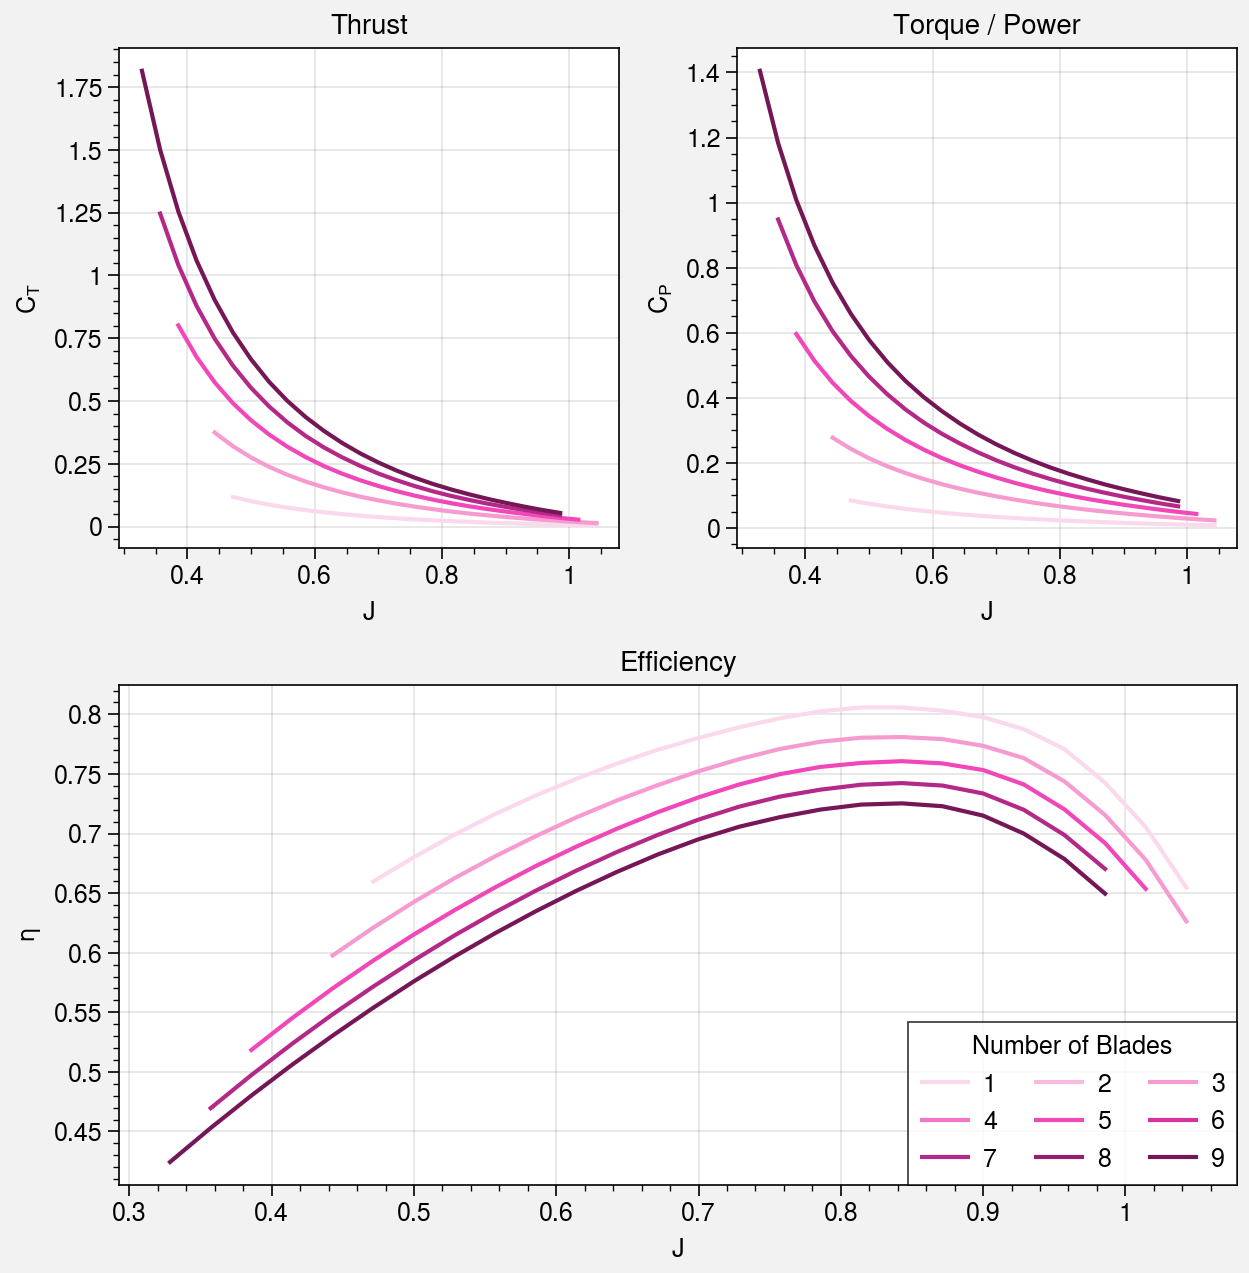

In [13]:
_array = [[1, 2], [3, 3]]
fig, axes = plot.subplots(array=_array, share=0)

for B in range(B0, BF):

    mask = results_df["B"] == B
    _results_df = results_df.loc[mask].set_index("J").drop("B", axis=1)

    ############
    # Thrust
    ############
    ax = axes[0]
    thrust = _results_df["CT"]
    thrust.name = str(B)
    lines = ax.plot(
        thrust,
        cycle="plum",
    )
    ax.format(
        title="Thrust",
        ylabel="$C_T$",
    )

    ############
    # Torque
    ############
    ax = axes[1]
    torque = _results_df["CP"]
    torque.name = str(B)

    ax.plot(
        torque,
        cycle="plum",
    )
    ax.format(
        title="Torque / Power",
        ylabel="$C_P$",
    )

    ############
    # Efficiency
    ############
    ax = axes[-1]
    eta = _results_df["eta"]
    eta.name = str(B)
    ax.plot(eta,  cycle="plum")
    ax.format(title="Efficiency", ylabel="$\eta$")

axes[-1].legend(title="Number of Blades")

fig.save("Number_of_blades.pdf")